# Examine parameters of circuits in the form of binding energies

Here we look at the statistics underlying the parameters of a dataset of randomly generated circuits. We have generated roughly 1 million circuits and calculated their interaction parameters by simulating their binding energies. In this case, all nodes in the circuit are RNAs, so an RNA interaction simulator (IntaRNA) was used to estimate the minimum free energy of binding between all species within a circuit. 

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from src.srv.parameter_prediction.interactions import INTERACTION_TYPES
from src.srv.io.loaders.experiment_loading import INTERACTION_FILE_ADDONS
from src.utils.results.analytics.naming import get_true_interaction_cols
from src.utils.misc.string_handling import prettify_keys_for_label


In [11]:
fn = '../data/generate_seqs_flexible/2023_04_17_205800/circuit_stats.csv'
data = pd.read_csv(fn)

While the interaction calculated by the RNA simulator is in units of energy (in kcal/mol and denoted as `energies`), we calculated the $K_{eq}$ equilibrium constants (denoted as `eqconstants`) and the binding rates of dissociation (denoted as `binding_rates_dissociation`) through a nonlinear mapping (detailed in earlier explanation notebook). The interaction columns ending with `'_i-j'` indicate the pair of species that are interacting, so column `energies_0-0` refers to the minimum free binding energy between species 0 and itself.

In [12]:
data.columns

Index(['name', 'interacting', 'self_interacting', 'num_interacting',
       'num_self_interacting', 'binding_sites_0-0', 'binding_sites_0-1',
       'binding_sites_0-2', 'binding_sites_1-0', 'binding_sites_1-1',
       'binding_sites_1-2', 'binding_sites_2-0', 'binding_sites_2-1',
       'binding_sites_2-2', 'binding_rates_dissociation_0-0',
       'binding_rates_dissociation_0-1', 'binding_rates_dissociation_0-2',
       'binding_rates_dissociation_1-0', 'binding_rates_dissociation_1-1',
       'binding_rates_dissociation_1-2', 'binding_rates_dissociation_2-0',
       'binding_rates_dissociation_2-1', 'binding_rates_dissociation_2-2',
       'energies_0-0', 'energies_0-1', 'energies_0-2', 'energies_1-0',
       'energies_1-1', 'energies_1-2', 'energies_2-0', 'energies_2-1',
       'energies_2-2', 'eqconstants_0-0', 'eqconstants_0-1', 'eqconstants_0-2',
       'eqconstants_1-0', 'eqconstants_1-1', 'eqconstants_1-2',
       'eqconstants_2-0', 'eqconstants_2-1', 'eqconstants_2-2',
      

We expand these per-species columns into a pooled column for each interaction type.

In [13]:
datam = data.melt(['name'], value_vars=get_true_interaction_cols(data, INTERACTION_TYPES[0]), var_name='idx', value_name=INTERACTION_TYPES[0])
for i in INTERACTION_TYPES[1:]:
    dfm = data.melt(['name'], value_vars=get_true_interaction_cols(data, i), var_name='_', value_name=i)
    datam[i] = dfm[i]

Text(0.5, 0.98, '$10^6$ Randomly generated circuits')

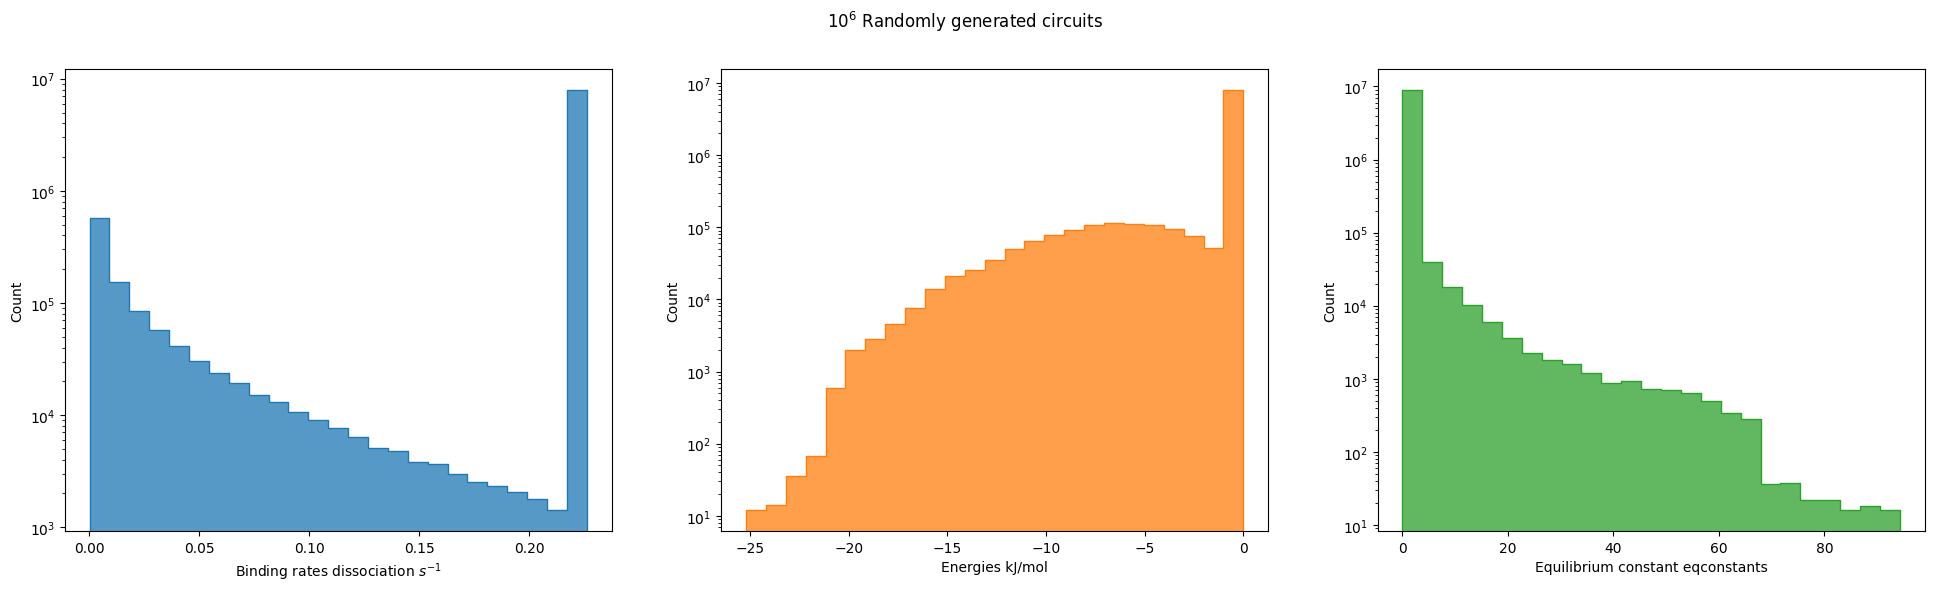

In [36]:
plt.figure(figsize=(8*len(INTERACTION_TYPES), 6))
palette = sns.color_palette()
for ii, i in enumerate(INTERACTION_TYPES):
    ax = plt.subplot(1, len(INTERACTION_TYPES), ii+1)
    sns.histplot(datam, x=i, element='step', log_scale=[False, True], color=sns.color_palette()[ii])
    plt.xlabel(prettify_keys_for_label(i) + f' {INTERACTION_FILE_ADDONS[i]}')
plt.suptitle(f'$10^{int(np.log10(len(data)))}$ Randomly generated circuits')

## Statistics of randomly generated circuits

Below are some stats on a batch of $10^6$ circuits that were generated randomly, albeit from a distribution of RNA nucleotides where each had a probability weighting corresponding to its abundance in the E. coli genome. Species are considered interacting if the equilibrium constant is greater than 1. Something that becomes obvious when grouping the binding energies by the number of interacting and self-interacting RNA species is that
- only 25/20000 = 0.125% circuits have 3 interactions (between different species)
- self-interacting species do not reach as negative binding energies
- the stronger the binding energy, the more nucleotides are bound together
- the most negative binding energy (ca. -9kcal/mol) corresponds to an equilibrium constant (ca. 0.01) from the fluorescence parameterisation that is still well below $K = 1$, meaning that if the criteria for species interacting were based on this new equilibrium constant, none of the circuits would be considered interacting. Perhaps 

In [ ]:

def undo_bplist(bp):
    return np.array([[int(i) for i in p.replace('(', '').replace(')', '').replace('nan', '0').split(',')] for p in str(bp).split(':')])

for c in stats.columns:
    if 'binding_sites_' in c and not (('counts' in c) or ('bindratio' in c)):
        stats[c + '_counts'] = stats[c].apply(str).apply(
            lambda x: len(x.split('nan')[0].split(':')) - (x == 'nan'))
        stats[c + '_bindratio'] = stats[c].apply(str).apply(
            lambda x: (undo_bplist(x).T[0, -1] - undo_bplist(x).T[0, 0]) / (len(undo_bplist(x)) - 1))

aggd = {c: 'mean'
        for c in stats.columns if ('binding_sites_' in c) and (('_counts' in c) or ('_bindratio' in c))}
aggd.update({c: ['mean',
                 lambda x: equilibrium_constant_fluorescence(np.mean(x), initial)]
             for c in stats.columns if 'energies_' in c})

stats.groupby(['num_interacting', 'num_self_interacting'], as_index=False).agg(aggd)
# .rename(columns={'<lambda_0>': 'mean_K-from-F'})


The following plots may be a bit misleading, as they appear to maintain the true spread of each of the features, but this is not the case - each stacked bar plot is adding up the blocks together, so a bar going from 0-100 with 5 blocks would mean each block has a value of around 20, while a bar that spans across 0 has blocks with negative values added together. The purpose is to show the rough length of each block, as well as highlighting differences between the spans of blocks at different numbers of interaction. For example, self-interactions tend to have a larger variance. The new equilibrium constant also has a smaller set of means compared to the original Gibbs equation K, for which a $\Delta G$ of 30kcal was given if the RNA simulator did not predict any binding.

In [ ]:

aggd = {c: 'mean'
        for c in stats.columns if ('binding_sites_' in c) and ('_counts' in c)}

stats.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Binding sites spread',
    mark_right=True)
plt.xlabel('Number of binding sites')
plt.show()

aggd = {c: 'mean'
        for c in stats.columns if 'energies_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Stacked spread of energies',
    mark_right=True)
plt.xlabel('kcal/mol')
plt.show()
plt.close()

aggd = {c: 'mean'
        for c in stats.columns if 'eqconstants_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Mean K',
    mark_right=True)
plt.xlabel('K')
plt.show()
plt.close()

aggd = {c: lambda x: equilibrium_constant_fluorescence(np.mean(x), initial)
        for c in stats.columns if 'energies_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd).rename(columns={'<lambda_0': 'mean_K-from-F'}).plot(
    x='num_interacting',
    kind='barh',
    stacked=True,
    title='Mean K from parameterised fluorescence',
    mark_right=True)
plt.xlabel('K')
plt.show()
plt.close()


In [ ]:
aggd = {c: 'mean'
        for c in stats.columns if 'energies_' in c}
stats.groupby('num_interacting', as_index=False).agg(aggd)